In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import defaultdict
import math
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import random
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")

data

,label,title,content
0,3,Ernie Cox,Ernest Ernie Cox (February 17 1894 – February...
1,10,Holosteum,Holosteum is a genus of plants in the Pink fa...
2,9,Pestarella tyrrhena,Pestarella tyrrhena (formerly Callianassa tyr...
3,1,MidSun Junior High School,MidSun Junior High School is a Canadian middl...
4,6,St James' Church Wrightington Bar,St James' Church Wrightington Bar is in Churc...
...,...,...,...
139995,9,Daedalochila uvulifera,Daedalochila uvulifera common name the penins...
139996,7,Nădrag River,The Nădrag River is a tributary of the Timiş ...
139997,11,Ready to Deal,Ready to Deal is the third solo album by Aust...
139998,0,Egosoft,Egosoft is a computer game developer founded ...


In [3]:
unique_words_conut = len(data['content'].str.split().explode().str.lower().unique())

In [3]:


class NaiveBayes:
    def __init__(self):
        self.prob_classes = None
        self.word_probs = None
        self.vocab = None
        self.smoothening = None
        self.classes = None
        pass

    def get_class_prob(self,df,class_col = "label"):
        self.prob_classes ={}

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)

        return self.prob_classes

    def get_vocab(self,df,text_col = "content"):
        self.vocab = set()
        all_words = []
        for tokens in df[text_col]:
            all_words.extend(tokens)
            
            self.vocab.update(tokens)

        self.vocab.add("<UNK>")
        return self.vocab
    


        
    def fit(self, df, smoothening, class_col = "label", text_col = "content"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        

        self.prob_classes = self.get_class_prob(df,class_col)


        
        self.vocab = self.get_vocab(df,text_col)

        self.word_probs = {}
        words_cnt = {c:defaultdict(int) for c in self.classes}   
        total_words_of_class = {c:0 for c in self.classes}

        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            for token in tokens:
                words_cnt[cls][token] += 1
                total_words_of_class[cls] += 1

        vocab_size = len(self.vocab) 

        for cls in self.classes:
           
            self.word_probs[cls] = {}
            denom = total_words_of_class[cls] + smoothening * vocab_size

            for word in self.vocab:
                if word == "<UNK>":
                    cnt = 0
                else:
                    cnt = words_cnt[cls].get(word, 0)
                cnt += smoothening

                self.word_probs[cls][word] = cnt / denom


        pass
    
    def predict(self, df, text_col = "content", predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.
        """
       
        predictions = []
        
      
        unknown_word_count = 0
        total_word_count = 0
        
        for _, row in df.iterrows():
            
                
            tokens = row[text_col]
            
            
            log_probs = {}
            
            for c in self.classes:
               
                log_probs[c] = math.log(self.prob_classes[c])
                
                
                for token in tokens:
                    total_word_count += 1
                    
                    if token not in self.word_probs[c]:
                        token = "<UNK>"
                        unknown_word_count += 1
                    
                    log_probs[c] += math.log(self.word_probs[c][token])
            
           
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)
        df[predicted_col] = predictions    
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):

        frequency_of_words = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(frequency_of_words)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()

In [5]:


class NaiveBayesPreprocess:
    def __init__(self):
        self.prob_classes = None
        self.word_probs = None
        self.vocab = None
        self.smoothening = None
        self.classes = None
        pass
    


    def preprocess_text(self,df, text_col="content"):

        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha() 
            ]
        )
        return df

        
    def fit(self, df, smoothening, class_col = "label", text_col = "content"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        df = self.preprocess_text(df, text_col)
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        self.prob_classes ={}

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        self.vocab = set()
        all_words = []
        for tokens in df[text_col]:
            all_words.extend(tokens)
            
            self.vocab.update(tokens)

        self.vocab.add("<UNK>")
        self.word_probs = {}
        words_cnt = {c:defaultdict(int) for c in self.classes}   
        total_words_of_class = {c:0 for c in self.classes}

        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            for token in tokens:
                words_cnt[cls][token] += 1
                total_words_of_class[cls] += 1

        vocab_size = len(self.vocab) 

        for cls in self.classes:
            
            self.word_probs[cls] = {}
            denom = total_words_of_class[cls] + smoothening * vocab_size

            for word in self.vocab:
                if word == "<UNK>":
                    cnt = 0
                else:
                    cnt = words_cnt[cls].get(word, 0)
                cnt += smoothening

                self.word_probs[cls][word] = cnt / denom


        pass
    
    def predict(self, df, text_col = "content", predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.
        """
        df = self.preprocess_text(df, text_col)
        predictions = []
        
      
        unknown_word_count = 0
        total_word_count = 0
        
        for _, row in df.iterrows():
            
                
            tokens = row[text_col]
            
            
            log_probs = {}
            
            for c in self.classes:
               
                log_probs[c] = math.log(self.prob_classes[c])
                
                
                for token in tokens:
                    total_word_count += 1
                    
                    if token not in self.word_probs[c]:
                        token = "<UNK>"
                        unknown_word_count += 1
                    
                    log_probs[c] += math.log(self.word_probs[c][token])
            
           
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)
        df[predicted_col] = predictions    
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()
        

In [4]:


class NaiveBayesBigram:
    def __init__(self):
        self.prob_classes = None
        self.word_probs = None
        self.vocab = None
        self.smoothening = None
        self.classes = None
        pass

    def make_bigrams(self,tokens):
        bigrams = []
        bigrams.extend(tokens)
        for i in range(len(tokens)-1):
            bigrams.append(tokens[i] + " " + tokens[i+1])
        return bigrams    
    

    def preprocess_text(self,df, text_col="content"):
        """
        Apply stemming + stopword removal to tokenized text in the DataFrame.
        Args:
            df (pd.DataFrame): DataFrame with tokenized text column
            text_col (str): Column containing list of tokens
        Returns:
            pd.DataFrame with updated text_col
        """
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha()  # keep only non-stopwords + alphabetic
            ]
        )
        return df

        
    def fit(self, df, smoothening, class_col = "label", text_col = "content"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        df = self.preprocess_text(df, text_col)
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        self.prob_classes ={}

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        self.vocab = set()
        all_words = []
        for tokens in df[text_col]:
            feature = self.make_bigrams(tokens)
            all_words.extend(feature)
            self.vocab.update(feature)

        self.vocab.add("<UNK>")
        self.word_probs = {}
        words_cnt = {c:defaultdict(int) for c in self.classes}   
        total_words_of_class = {c:0 for c in self.classes}

        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            for feature in features:
                words_cnt[cls][feature] += 1
                total_words_of_class[cls] += 1

        vocab_size = len(self.vocab) 

        for cls in self.classes:
           
            self.word_probs[cls] = {}
            denom = total_words_of_class[cls] + smoothening * vocab_size

            for word in self.vocab:
                if word == "<UNK>":
                    cnt = 0
                else:
                    cnt = words_cnt[cls].get(word, 0)
                cnt += smoothening

                self.word_probs[cls][word] = cnt / denom


        pass
    
    def predict(self, df, text_col = "content", predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.
        """
        df = self.preprocess_text(df, text_col)
        predictions = []
        
      
        unknown_word_count = 0
        total_word_count = 0
        
        for _, row in df.iterrows():
            
                
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            
            
            log_probs = {}
            
            for c in self.classes:
               
                log_probs[c] = math.log(self.prob_classes[c])
                
                
                for token in features:
                    total_word_count += 1
                    
                    if token not in self.word_probs[c]:
                        token = "<UNK>"
                        unknown_word_count += 1
                    
                    log_probs[c] += math.log(self.word_probs[c][token])
            
           
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)
        df[predicted_col] = predictions    
        
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        print(f"unknown_word_count: {unknown_word_count}, total_word_count: {total_word_count}")
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()
        

In [5]:


class NaiveBayesWithoutPreprocessBigram:
    def __init__(self):
        self.prob_classes = None
        self.word_probs = None
        self.vocab = None
        self.smoothening = None
        self.classes = None
        pass

    def make_bigrams(self,tokens):
        bigrams = []
        bigrams.extend(tokens)
        for i in range(len(tokens)-1):
            bigrams.append(tokens[i] + " " + tokens[i+1])
        return bigrams    
    

    def preprocess_text(self,df, text_col="content"):
        """
        Apply stemming + stopword removal to tokenized text in the DataFrame.
        Args:
            df (pd.DataFrame): DataFrame with tokenized text column
            text_col (str): Column containing list of tokens
        Returns:
            pd.DataFrame with updated text_col
        """
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha()  # keep only non-stopwords + alphabetic
            ]
        )
        return df

        
    def fit(self, df, smoothening, class_col = "label", text_col = "content"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        # df = self.preprocess_text(df, text_col)
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        self.prob_classes ={}

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        self.vocab = set()
        all_words = []
        for tokens in df[text_col]:
            feature = self.make_bigrams(tokens)
            all_words.extend(feature)
            self.vocab.update(feature)

        self.vocab.add("<UNK>")
        self.word_probs = {}
        words_cnt = {c:defaultdict(int) for c in self.classes}   
        total_words_of_class = {c:0 for c in self.classes}

        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            for feature in features:
                words_cnt[cls][feature] += 1
                total_words_of_class[cls] += 1

        vocab_size = len(self.vocab) 

        for cls in self.classes:
           
            self.word_probs[cls] = {}
            denom = total_words_of_class[cls] + smoothening * vocab_size

            for word in self.vocab:
                if word == "<UNK>":
                    cnt = 0
                else:
                    cnt = words_cnt[cls].get(word, 0)
                cnt += smoothening

                self.word_probs[cls][word] = cnt / denom


        pass
    
    def predict(self, df, text_col = "content", predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.
        """
        # df = self.preprocess_text(df, text_col)
        predictions = []
        
      
        unknown_word_count = 0
        total_word_count = 0
        
        for _, row in df.iterrows():
            
                
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            
            
            log_probs = {}
            
            for c in self.classes:
               
                log_probs[c] = math.log(self.prob_classes[c])
                
                
                for token in features:
                    total_word_count += 1
                    
                    if token not in self.word_probs[c]:
                        token = "<UNK>"
                        unknown_word_count += 1
                    
                    log_probs[c] += math.log(self.word_probs[c][token])
            
           
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)
        df[predicted_col] = predictions    
        
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        print(f"unknown_word_count: {unknown_word_count}, total_word_count: {total_word_count}")
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()
        

In [6]:
def accuracy(df, class_col = "label", predicted_col = "Predicted"):
    correct = (df[class_col] == df[predicted_col]).sum()
    total = len(df)
    return correct / total

def precision_recall(df, class_col = "label", predicted_col = "Predicted", positive_class=1):
    tp = ((df[class_col] == positive_class) & (df[predicted_col] == positive_class)).sum()
    fp = ((df[class_col] != positive_class) & (df[predicted_col] == positive_class)).sum()
    fn = ((df[class_col] == positive_class) & (df[predicted_col] != positive_class)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [7]:
data['content'] = data['content'].str.split()
data['title'] = data['title'].str.split()
data_test['title'] = data_test['title'].str.split()
data_test['content'] = data_test['content'].str.split()

In [8]:
NB = NaiveBayes()
NB.fit(data, smoothening = 1.0, class_col = "label", text_col = "content")
NB.predict(data_test, text_col = "content", predicted_col = "Predicted")
NB.predict(data, text_col = "content", predicted_col = "Predicted")
# print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
# for i in range(14):
#     print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
#     print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")
    



0.9603428571428572
0.9788642857142857


In [12]:
NB.predict(data_test, text_col = "content", predicted_col = "Predicted")
NB.predict(data, text_col = "content", predicted_col = "Predicted")

0.9603428571428572
0.9788642857142857


In [ ]:
for i in range(14):
    NB.plot_wordcloud(i, max_words=100)

In [16]:
NB1 = NaiveBayesPreprocess()
NB1.fit(data, smoothening = 1.0, class_col = "label", text_col = "content")
NB1.predict(data_test, text_col = "content", predicted_col = "Predicted")
NB1.predict(data, text_col = "content", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.9429428571428572
0.9617785714285715
accuracy on test data: 0.9429428571428572
precison and recall for class 0: (0.9139784946236559, 0.85)
f1 score for class 0: 0.8808290155440415
precison and recall for class 1: (0.9418335901386748, 0.978)
f1 score for class 1: 0.9595761381475667
precison and recall for class 2: (0.9063400576368876, 0.7548)
f1 score for class 2: 0.8236577913574857
precison and recall for class 3: (0.9654223968565815, 0.9828)
f1 score for class 3: 0.9740336967294351
precison and recall for class 4: (0.9596967278531524, 0.962)
f1 score for class 4: 0.9608469836196565
precison and recall for class 5: (0.9568932038834952, 0.9856)
f1 score for class 5: 0.9710344827586207
precison and recall for class 6: (0.946271050521251, 0.944)
f1 score for class 6: 0.9451341609931918
precison and recall for class 7: (0.9712258573117856, 0.9856)
f1 score for class 7: 0.9783601350009926
precison and recall for class 8: (0.998330550918197, 0.9568)
f1 score for class 8: 0.977124183006536
p

In [ ]:
for i in range(14):
    NB1.plot_wordcloud(i, max_words=100)

In [18]:
NB2 = NaiveBayesBigram()
NB2.fit(data, smoothening = 1.0, class_col = "label", text_col = "content")
NB2.predict(data_test, text_col = "content", predicted_col = "Predicted")
NB2.predict(data, text_col = "content", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.9544
unknown_word_count: 4908302, total_word_count: 21808500
0.9892142857142857
unknown_word_count: 742, total_word_count: 86893282
accuracy on test data: 0.9544
precison and recall for class 0: (0.9394329896907216, 0.8748)
f1 score for class 0: 0.9059652029826015
precison and recall for class 1: (0.9473076923076923, 0.9852)
f1 score for class 1: 0.9658823529411765
precison and recall for class 2: (0.9429106223678053, 0.806)
f1 score for class 2: 0.8690963985335347
precison and recall for class 3: (0.9693877551020408, 0.988)
f1 score for class 3: 0.9786053882725833
precison and recall for class 4: (0.9656549520766773, 0.9672)
f1 score for class 4: 0.9664268585131893
precison and recall for class 5: (0.9617486338797814, 0.9856)
f1 score for class 5: 0.9735282497036744
precison and recall for class 6: (0.953479125248509, 0.9592)
f1 score for class 6: 0.9563310069790627
precison and recall for class 7: (0.9732072498029944, 0.988)
f1 score for class 7: 0.9805478364430329
precison and rec

In [19]:
data = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")
data['content'] = data['content'].str.split()
data['title'] = data['title'].str.split()
data_test['title'] = data_test['title'].str.split()
data_test['content'] = data_test['content'].str.split()

In [ ]:
data_test

,label,title,content
0,4,"[Lajos, Drahos]","[Lajos, Drahos, (7, March, 1895, -, 2, June, 1..."
1,5,"[USS, Huntsville, (1857)]","[USS, Huntsville, was, a, steamer, acquired, b..."
2,0,[SCAFCO],"[Founded, in, 1954, by, Ben, G., Stone, SCAFCO..."
3,6,"[McLean's, Mansion]","[McLean's, Mansion, (originally, Holly, Lea), ..."
4,5,"[Avioane, Craiova, IAR-93, Vultur]","[The, Avioane, Craiova, IAR-93, Vultur, (Eagle..."
...,...,...,...
34995,8,"[Pianki, Masovian, Voivodeship]","[Pianki, [ˈpjaŋki], is, a, village, in, the, a..."
34996,7,"[Big, Timber, Creek]","[Big, Timber, Creek, is, a, 5.6-mile-long, (9...."
34997,3,"[Shona, Barbour]","[Shona, Barbour, (born, July, 4, 1979, Calgary..."
34998,13,"[Philosophy, and, Literature]","[Philosophy, and, Literature, is, an, academic..."


In [ ]:
NB3 = NaiveBayesWithoutPreprocessBigram()
NB3.fit(data, smoothening = 1.0, class_col = "label", text_col = "content")
NB3.predict(data_test, text_col = "content", predicted_col = "Predicted")
NB3.predict(data, text_col = "content", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.9545714285714286
unknown_word_count: 4912740, total_word_count: 21836080
0.9889571428571429
unknown_word_count: 2881116, total_word_count: 86904090
accuracy on test data: 0.9545714285714286
precison and recall for class 0: (0.9395109395109396, 0.876)
f1 score for class 0: 0.9066445870420203
precison and recall for class 1: (0.946923076923077, 0.9848)
f1 score for class 1: 0.9654901960784315
precison and recall for class 2: (0.943272386310361, 0.8048)
f1 score for class 2: 0.8685516943665011
precison and recall for class 3: (0.9701492537313433, 0.988)
f1 score for class 3: 0.9789932619896948
precison and recall for class 4: (0.9656686626746507, 0.9676)
f1 score for class 4: 0.9666333666333666
precison and recall for class 5: (0.9621241702459976, 0.9856)
f1 score for class 5: 0.9737206085753802
precison and recall for class 6: (0.9531374106433678, 0.96)
f1 score for class 6: 0.9565563969709048
precison and recall for class 7: (0.9735908553409539, 0.988)
f1 score for class 7: 0.98074250

Using Bigram alone

In [24]:


class NaiveBayesBigramTemp:
    def __init__(self):
        self.prob_classes = None
        self.word_probs = None
        self.vocab = None
        self.smoothening = None
        self.classes = None
        pass

    def make_bigrams(self,tokens):
        bigrams = []
        # bigrams.extend(tokens)
        for i in range(len(tokens)-1):
            bigrams.append(tokens[i] + " " + tokens[i+1])
        return bigrams    
    

    def preprocess_text(self,df, text_col="content"):
        """
        Apply stemming + stopword removal to tokenized text in the DataFrame.
        Args:
            df (pd.DataFrame): DataFrame with tokenized text column
            text_col (str): Column containing list of tokens
        Returns:
            pd.DataFrame with updated text_col
        """
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha()  # keep only non-stopwords + alphabetic
            ]
        )
        return df

        
    def fit(self, df, smoothening, class_col = "label", text_col = "content"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        df = self.preprocess_text(df, text_col)
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        self.prob_classes ={}

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        self.vocab = set()
        all_words = []
        for tokens in df[text_col]:
            feature = self.make_bigrams(tokens)
            all_words.extend(feature)
            self.vocab.update(feature)

        self.vocab.add("<UNK>")
        self.word_probs = {}
        words_cnt = {c:defaultdict(int) for c in self.classes}   
        total_words_of_class = {c:0 for c in self.classes}

        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            for feature in features:
                words_cnt[cls][feature] += 1
                total_words_of_class[cls] += 1

        vocab_size = len(self.vocab) 

        for cls in self.classes:
           
            self.word_probs[cls] = {}
            denom = total_words_of_class[cls] + smoothening * vocab_size

            for word in self.vocab:
                if word == "<UNK>":
                    cnt = 0
                else:
                    cnt = words_cnt[cls].get(word, 0)
                cnt += smoothening

                self.word_probs[cls][word] = cnt / denom


        pass
    
    def predict(self, df, text_col = "content", predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.
        """
        df = self.preprocess_text(df, text_col)
        predictions = []
        
      
        unknown_word_count = 0
        total_word_count = 0
        
        for _, row in df.iterrows():
            
                
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            
            
            log_probs = {}
            
            for c in self.classes:
               
                log_probs[c] = math.log(self.prob_classes[c])
                
                
                for token in features:
                    total_word_count += 1
                    
                    if token not in self.word_probs[c]:
                        token = "<UNK>"
                        unknown_word_count += 1
                    
                    log_probs[c] += math.log(self.word_probs[c][token])
            
           
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)
        df[predicted_col] = predictions    
        
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        print(f"unknown_word_count: {unknown_word_count}, total_word_count: {total_word_count}")
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()



NBtemp = NaiveBayesBigramTemp()
NBtemp.fit(data, smoothening = 1.0, class_col = "label", text_col = "content")
NBtemp.predict(data_test, text_col = "content", predicted_col = "Predicted")
NBtemp.predict(data, text_col = "content", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")
    


        

0.9437428571428571
unknown_word_count: 4401334, total_word_count: 10673040
0.9968
unknown_word_count: 2098880, total_word_count: 42472108
accuracy on test data: 0.9437428571428571
precison and recall for class 0: (0.9460400348128808, 0.8696)
f1 score for class 0: 0.906210921217174
precison and recall for class 1: (0.9293539856441254, 0.984)
f1 score for class 1: 0.9558966388187293
precison and recall for class 2: (0.9368171021377673, 0.7888)
f1 score for class 2: 0.8564603691639522
precison and recall for class 3: (0.9586260733801717, 0.9824)
f1 score for class 3: 0.9703674436981431
precison and recall for class 4: (0.9433438985736925, 0.9524)
f1 score for class 4: 0.9478503184713376
precison and recall for class 5: (0.963226571767497, 0.9744)
f1 score for class 5: 0.9687810697951879
precison and recall for class 6: (0.9528455284552846, 0.9376)
f1 score for class 6: 0.9451612903225807
precison and recall for class 7: (0.9542767047694127, 0.9684)
f1 score for class 7: 0.9612864800476475

#Using Title

In [20]:

NB = NaiveBayes()
NB.fit(data, smoothening = 1.0, class_col = "label", text_col = "title")
NB.predict(data_test, text_col = "title", predicted_col = "Predicted")
NB.predict(data, text_col = "title", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")
    



0.6714
0.9052785714285714
accuracy on test data: 0.6714
precison and recall for class 0: (0.8234544295729764, 0.5168)
f1 score for class 0: 0.6350454657163922
precison and recall for class 1: (0.8423799582463466, 0.9684)
f1 score for class 1: 0.9010048381094158
precison and recall for class 2: (0.4696223316912972, 0.3432)
f1 score for class 2: 0.39657961636237576
precison and recall for class 3: (0.5424187725631769, 0.4808)
f1 score for class 3: 0.5097540288379984
precison and recall for class 4: (0.5325700750098697, 0.5396)
f1 score for class 4: 0.5360619908603219
precison and recall for class 5: (0.9069160504567203, 0.834)
f1 score for class 5: 0.8689310272973536
precison and recall for class 6: (0.8235518292682927, 0.8644)
f1 score for class 6: 0.8434816549570647
precison and recall for class 7: (0.9014479215319944, 0.772)
f1 score for class 7: 0.8317173023055376
precison and recall for class 8: (0.9297771775827144, 0.5508)
f1 score for class 8: 0.691785983421251
precison and recall

In [21]:

NB1 = NaiveBayesPreprocess()
NB1.fit(data, smoothening = 1.0, class_col = "label", text_col = "title")
NB1.predict(data_test, text_col = "title", predicted_col = "Predicted")
NB1.predict(data, text_col = "title", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")
    

0.5895142857142858
0.8268214285714286
accuracy on test data: 0.5895142857142858
precison and recall for class 0: (0.6084189916789036, 0.4972)
f1 score for class 0: 0.5472154963680387
precison and recall for class 1: (0.8066666666666666, 0.968)
f1 score for class 1: 0.88
precison and recall for class 2: (0.3581541688515994, 0.2732)
f1 score for class 2: 0.3099614250056728
precison and recall for class 3: (0.4594229035166817, 0.4076)
f1 score for class 3: 0.4319626960576516
precison and recall for class 4: (0.4511217948717949, 0.4504)
f1 score for class 4: 0.45076060848678945
precison and recall for class 5: (0.8507209499575912, 0.8024)
f1 score for class 5: 0.8258542610127625
precison and recall for class 6: (0.7492947813822285, 0.85)
f1 score for class 6: 0.7964767616191903
precison and recall for class 7: (0.8525059665871122, 0.7144)
f1 score for class 7: 0.7773667029379759
precison and recall for class 8: (0.9088339222614841, 0.5144)
f1 score for class 8: 0.6569604086845465
precison 

In [ ]:

NB2 = NaiveBayesBigram()
NB2.fit(data, smoothening = 1.0, class_col = "label", text_col = "title")
NB2.predict(data_test, text_col = "title", predicted_col = "Predicted")
NB2.predict(data, text_col = "title", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.5906
unknown_word_count: 690592, total_word_count: 1626100
0.9062642857142857
unknown_word_count: 70, total_word_count: 6507858
accuracy on test data: 0.5906
precison and recall for class 0: (0.6106237816764133, 0.5012)
f1 score for class 0: 0.5505272407732865
precison and recall for class 1: (0.8177822853279243, 0.9676)
f1 score for class 1: 0.8864052766581166
precison and recall for class 2: (0.36, 0.2808)
f1 score for class 2: 0.3155056179775281
precison and recall for class 3: (0.4567956795679568, 0.406)
f1 score for class 3: 0.4299025836509954
precison and recall for class 4: (0.45209339774557167, 0.4492)
f1 score for class 4: 0.4506420545746388
precison and recall for class 5: (0.8510368176047397, 0.8044)
f1 score for class 5: 0.8270614846802384
precison and recall for class 6: (0.7594757350336522, 0.8576)
f1 score for class 6: 0.8055607739996243
precison and recall for class 7: (0.8532634587899, 0.7164)
f1 score for class 7: 0.7788649706457926
precison and recall for class 8: 

In [22]:

NB2 = NaiveBayesWithoutPreprocessBigram()
NB2.fit(data, smoothening = 1.0, class_col = "label", text_col = "title")
NB2.predict(data_test, text_col = "title", predicted_col = "Predicted")
NB2.predict(data, text_col = "title", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.5844857142857143
unknown_word_count: 712194, total_word_count: 1627206
0.9064428571428571
unknown_word_count: 0, total_word_count: 6508250
accuracy on test data: 0.5844857142857143
precison and recall for class 0: (0.6036911121903836, 0.4972)
f1 score for class 0: 0.545295020837903
precison and recall for class 1: (0.811981234211476, 0.9)
f1 score for class 1: 0.8537279453614114
precison and recall for class 2: (0.35755358076319915, 0.2736)
f1 score for class 2: 0.309993201903467
precison and recall for class 3: (0.4533213644524237, 0.404)
f1 score for class 3: 0.4272419627749577
precison and recall for class 4: (0.4488, 0.4488)
f1 score for class 4: 0.4488
precison and recall for class 5: (0.8461214165261383, 0.8028)
f1 score for class 5: 0.8238916256157636
precison and recall for class 6: (0.7522839072382291, 0.8564)
f1 score for class 6: 0.8009726898615788
precison and recall for class 7: (0.8500237304224015, 0.7164)
f1 score for class 7: 0.7775124810071631
precison and recall for

In [25]:
data['content+title'] =  data['title'] + data['content'] 
data_test['content+title'] =  data_test['title'] + data_test['content']



In [26]:
NB2 = NaiveBayes()
NB2.fit(data, smoothening = 1.0, class_col = "label", text_col = "content+title")
NB2.predict(data_test, text_col = "content+title", predicted_col = "Predicted")
NB2.predict(data, text_col = "content+title", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.94
0.9663071428571428
accuracy on test data: 0.94
precison and recall for class 0: (0.9109470026064292, 0.8388)
f1 score for class 0: 0.8733860891295294
precison and recall for class 1: (0.9479207151185387, 0.9756)
f1 score for class 1: 0.9615612063867534
precison and recall for class 2: (0.8918406072106262, 0.752)
f1 score for class 2: 0.8159722222222222
precison and recall for class 3: (0.9636219849742982, 0.9748)
f1 score for class 3: 0.9691787631735932
precison and recall for class 4: (0.9517022961203484, 0.9616)
f1 score for class 4: 0.956625547154795
precison and recall for class 5: (0.9560653188180405, 0.9836)
f1 score for class 5: 0.9696372239747634
precison and recall for class 6: (0.9410368025326474, 0.9512)
f1 score for class 6: 0.9460911080167098
precison and recall for class 7: (0.9708776072412436, 0.9868)
f1 score for class 7: 0.9787740527673081
precison and recall for class 8: (0.9966513185433236, 0.9524)
f1 score for class 8: 0.9740233176518716
precison and recall for

In [ ]:
NB2 = NaiveBayesBigram()
NB2.fit(data, smoothening = 1.0, class_col = "label", text_col = "content+title")


In [ ]:
NB2.predict(data_test, text_col = "content+title", predicted_col = "Predicted")
NB2.predict(data, text_col = "content+title", predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}")

0.9537142857142857
unknown_word_count: 5862948, total_word_count: 23918776
0.9917142857142857
unknown_word_count: 0, total_word_count: 95338768
accuracy on test data: 0.9537142857142857
precison and recall for class 0: (0.9386609071274298, 0.8692)
f1 score for class 0: 0.9025960539979231
precison and recall for class 1: (0.9468044393417527, 0.9896)
f1 score for class 1: 0.9677293174261686
precison and recall for class 2: (0.9408172851103804, 0.8012)
f1 score for class 2: 0.8654136962626917
precison and recall for class 3: (0.9693034238488784, 0.9852)
f1 score for class 3: 0.9771870660583217
precison and recall for class 4: (0.9644994016753091, 0.9672)
f1 score for class 4: 0.9658478130617136
precison and recall for class 5: (0.9614485981308412, 0.9876)
f1 score for class 5: 0.9743488555643252
precison and recall for class 6: (0.94972288202692, 0.9596)
f1 score for class 6: 0.9546358933545563
precison and recall for class 7: (0.974773354355538, 0.9892)
f1 score for class 7: 0.9819336906

In [ ]:


class NaiveBayesBigram:
    def __init__(self):
        self.prob_classes = None
        self.word_probs = None
        self.vocab = None
        self.smoothening = None
        self.classes = None
        pass

    def make_bigrams(self,tokens):
        bigrams = []
        bigrams.extend(tokens)
        for i in range(len(tokens)-1):
            bigrams.append(tokens[i] + " " + tokens[i+1])
        return bigrams    
    

    def preprocess_text(self,df, text_col="content"):
        """
        Apply stemming + stopword removal to tokenized text in the DataFrame.
        Args:
            df (pd.DataFrame): DataFrame with tokenized text column
            text_col (str): Column containing list of tokens
        Returns:
            pd.DataFrame with updated text_col
        """
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha()  # keep only non-stopwords + alphabetic
            ]
        )
        return df

        
    def fit(self, df, smoothening, class_col = "label", text_col = "content"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        df = self.preprocess_text(df, text_col)
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        self.prob_classes ={}

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        self.vocab = set()
        all_words = []
        for tokens in df[text_col]:
            feature = self.make_bigrams(tokens)
            all_words.extend(feature)
            self.vocab.update(feature)

        self.vocab.add("<UNK>")
        self.word_probs = {}
        words_cnt = {c:defaultdict(int) for c in self.classes}   
        total_words_of_class = {c:0 for c in self.classes}

        for _, row in df.iterrows():
            cls = row[class_col]
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            for feature in features:
                words_cnt[cls][feature] += 1
                total_words_of_class[cls] += 1

        vocab_size = len(self.vocab) 

        for cls in self.classes:
           
            self.word_probs[cls] = {}
            denom = total_words_of_class[cls] + smoothening * vocab_size

            for word in self.vocab:
                if word == "<UNK>":
                    cnt = 0
                else:
                    cnt = words_cnt[cls].get(word, 0)
                cnt += smoothening

                self.word_probs[cls][word] = cnt / denom


        pass
    
    def predict(self, df, text_col = "content", predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.
        """
        df = self.preprocess_text(df, text_col)
        predictions = []
        
      
        unknown_word_count = 0
        total_word_count = 0
        
        for _, row in df.iterrows():
            
                
            tokens = row[text_col]
            features = self.make_bigrams(tokens)
            
            
            log_probs = {}
            
            for c in self.classes:
               
                log_probs[c] = math.log(self.prob_classes[c])
                
                
                for token in features:
                    total_word_count += 1
                    
                    if token not in self.word_probs[c]:
                        token = "<UNK>"
                        unknown_word_count += 1
                    
                    log_probs[c] += math.log(self.word_probs[c][token])
            
           
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)
        df[predicted_col] = predictions    
        
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        print(f"unknown_word_count: {unknown_word_count}, total_word_count: {total_word_count}")
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()
        

#Using Both features independently 

In [27]:


class NaiveBayesMultifeature:
    def __init__(self):
        self.prob_classes = {}
        self.word_probs = {}
        self.vocab = {}
        self.smoothening = None
        self.classes = None
        self.feature_types = ['content', 'title']
        pass

    def make_bigrams(self,tokens):
        bigrams = []
        bigrams.extend(tokens)
        for i in range(len(tokens)-1):
            bigrams.append(tokens[i] + " " + tokens[i+1])
        return bigrams    
    

    def preprocess_text(self,df, text_col="content"):
        """
        Apply stemming + stopword removal to tokenized text in the DataFrame.
        Args:
            df (pd.DataFrame): DataFrame with tokenized text column
            text_col (str): Column containing list of tokens
        Returns:
            pd.DataFrame with updated text_col
        """
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha()  # keep only non-stopwords + alphabetic
            ]
        )
        return df

        
    def fit(self, df, smoothening,class_col = "label"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        for feature_type in self.feature_types:
            df = self.preprocess_text(df, feature_type)

        
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        
      

        for feature_type in self.feature_types:
            self.vocab[feature_type] = set()
            self.word_probs[feature_type] = {} 

            all_words = []
            for tokens in df[feature_type]:
                features = self.make_bigrams(tokens)
                all_words.extend(features)
                self.vocab[feature_type].update(features)

            self.vocab[feature_type].add("<UNK>")



        token_count = {feature_type : { c : defaultdict(int) for c in self.classes} for feature_type in self.feature_types}
        total_token_per_class = {feature_type : { c : 0 for c in self.classes} for feature_type in self.feature_types}



        for feature_type in self.feature_types:
            for _,row in df.iterrows():
                cls = row[class_col]
                tokens = row[feature_type]
                features = self.make_bigrams(tokens)

                for feature in features :

                    token_count[feature_type][cls][feature] += 1
                    total_token_per_class[feature_type][cls] += 1

        for feature_type in self.feature_types:
            vocab_size = len(self.vocab[feature_type]) 

            for cls in self.classes:
                self.word_probs[feature_type][cls] = {}

                denom = total_token_per_class[feature_type][cls] + smoothening * vocab_size

                for word in self.vocab[feature_type]:
                    if word == "<UNK>":
                        cnt = 0
                    else:
                        cnt = token_count[feature_type][cls].get(word, 0)
                    cnt += smoothening
                    self.word_probs[feature_type][cls][word] = cnt / denom        



        pass
    
    def predict(self, df, predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.

                
        """
        for feature_type in self.feature_types:
            df = self.preprocess_text(df, feature_type)


        predictions = []
        unknown_word_count = 0
        total_word_count = 0


        for _ , row in df.iterrows():
            log_probs = {}

            for c in self.classes:
                log_probs[c] = math.log(self.prob_classes[c])

                for feature_type in self.feature_types:
                    tokens = row[feature_type]

                    features = self.make_bigrams(tokens)

                    for feature in features:
                        if feature not in self.word_probs[feature_type][c]:
                            feature = "<UNK>"
                            unknown_word_count += 1
                        log_probs[c] += math.log(self.word_probs[feature_type][c][feature])
                        total_word_count += 1
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)

        df[predicted_col] = predictions

          
        
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        print(f"unknown_word_count: {unknown_word_count}, total_word_count: {total_word_count}")
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()
        

In [28]:
data = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")
data['content'] = data['content'].str.split()
data['title'] = data['title'].str.split()
data_test['title'] = data_test['title'].str.split()
data_test['content'] = data_test['content'].str.split()

In [ ]:
NB_Multi = NaiveBayesMultifeature()
NB_Multi.fit(data, smoothening = 1.0, class_col = "label")
NB_Multi.predict(data_test, predicted_col = "Predicted")
NB_Multi.predict(data, predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}") 

0.9583428571428572
unknown_word_count: 5586952, total_word_count: 23431912
0.99145
unknown_word_count: 28, total_word_count: 93401140
accuracy on test data: 0.9583428571428572
precison and recall for class 0: (0.9426615318784767, 0.8812)
f1 score for class 0: 0.9108951829646474
precison and recall for class 1: (0.9511913912375096, 0.99)
f1 score for class 1: 0.9702077616620932
precison and recall for class 2: (0.9509174311926606, 0.8292)
f1 score for class 2: 0.885897435897436
precison and recall for class 3: (0.9697208022021234, 0.9864)
f1 score for class 3: 0.9779892920880429
precison and recall for class 4: (0.9654213036565977, 0.9716)
f1 score for class 4: 0.9685007974481659
precison and recall for class 5: (0.9671232876712329, 0.9884)
f1 score for class 5: 0.9776458951533136
precison and recall for class 6: (0.9525316455696202, 0.9632)
f1 score for class 6: 0.9578361177406524
precison and recall for class 7: (0.9766982622432859, 0.9892)
f1 score for class 7: 0.9829093799682035
pre

In [ ]:
data.head()

,label,title,content,Predicted
0,3,"[erni, cox]","[ernest, erni, cox, februari, star, footbal, p...",3
1,10,[holosteum],"[holosteum, genus, plant, pink, famili, speci,...",10
2,9,"[pestarella, tyrrhena]","[pestarella, tyrrhena, callianassa, speci, tha...",9
3,1,"[midsun, junior, high, school]","[midsun, junior, high, school, canadian, middl...",1
4,6,"[st, church, wrightington, bar]","[st, church, wrightington, bar, church, lane, ...",6


In [ ]:
data_test.head()

,label,title,content,Predicted
0,4,"[lajo, draho]","[lajo, draho, march, june, hungarian, communis...",4
1,5,"[uss, huntsvil]","[uss, huntsvil, steamer, acquir, union, navi, ...",5
2,0,[scafco],"[found, ben, stone, scafco, corpor, privat, he...",0
3,6,[mansion],"[mansion, holli, homestead, christchurch, new,...",6
4,5,"[avioan, craiova, vultur]","[avioan, craiova, vultur, subson, close, suppo...",5


#1.7


1.7a

accuracy on test data: 0.0728


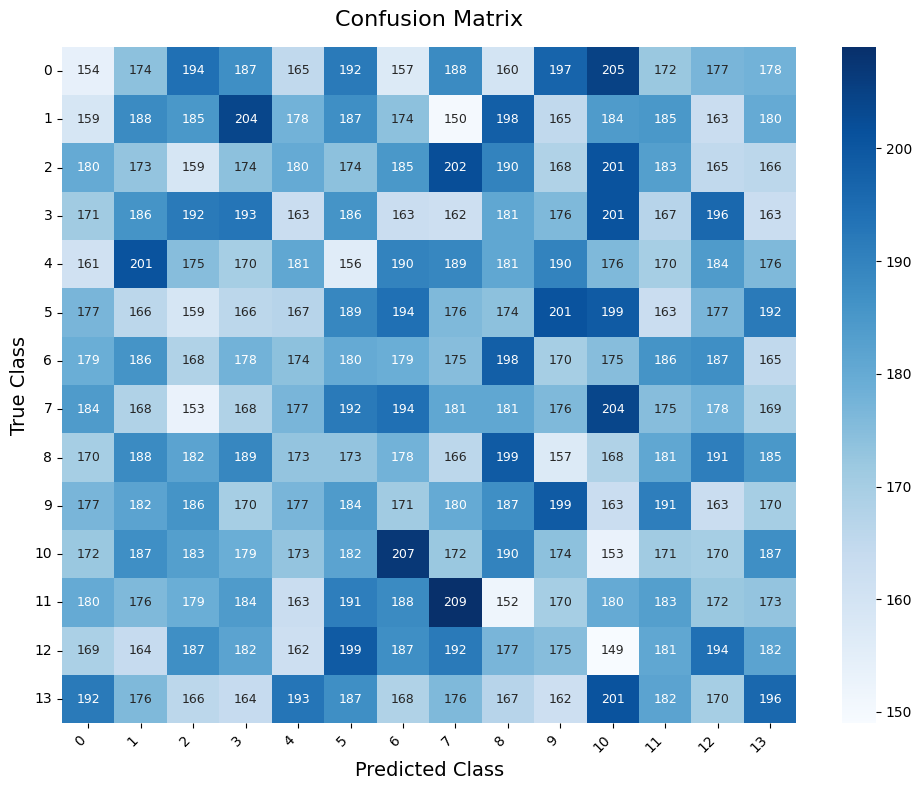

In [29]:

data_test['random_predict'] = [random.randint(0,13) for _ in range(len(data_test))]
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'random_predict')}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(df, true_col="label", pred_col="Predicted"):
    # Compute confusion matrix
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(df[true_col].unique())

    # Create a bigger, clearer plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True,          # display numbers
        fmt='d',             # integer format
        cmap='Blues',        # color map
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True,
        annot_kws={"size": 9}  # adjust font size for annotations
    )

    plt.title("Confusion Matrix", fontsize=16, pad=15)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(data_test, true_col="label", pred_col="random_predict")

1.7b

accuracy on test data: 0.07142857142857142


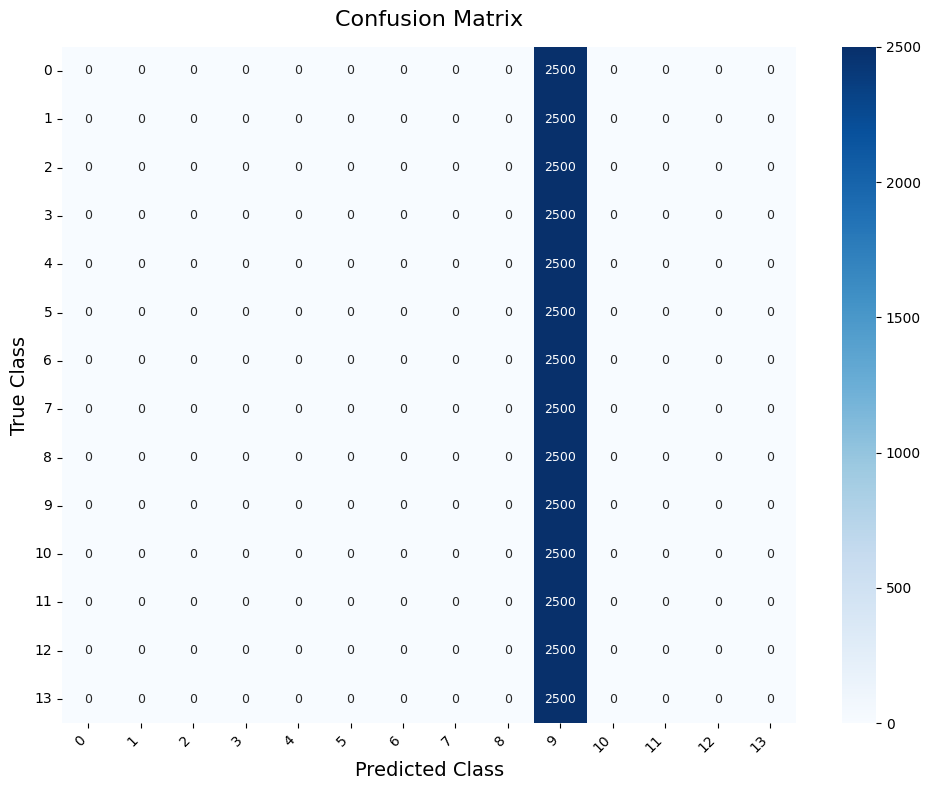

In [30]:
random_predict = random.randint(0,13)
data_test['random_predict'] = [random_predict for _ in range(len(data_test))]
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'random_predict')}")
plot_confusion_matrix(data_test, true_col="label", pred_col="random_predict")

In [ ]:
data_test.head()

,label,title,content,Predicted,random_predict
0,4,"[lajo, draho]","[lajo, draho, march, june, hungarian, communis...",4,5
1,5,"[uss, huntsvil]","[uss, huntsvil, steamer, acquir, union, navi, ...",5,5
2,0,[scafco],"[found, ben, stone, scafco, corpor, privat, he...",0,5
3,6,[mansion],"[mansion, holli, homestead, christchurch, new,...",6,5
4,5,"[avioan, craiova, vultur]","[avioan, craiova, vultur, subson, close, suppo...",5,5


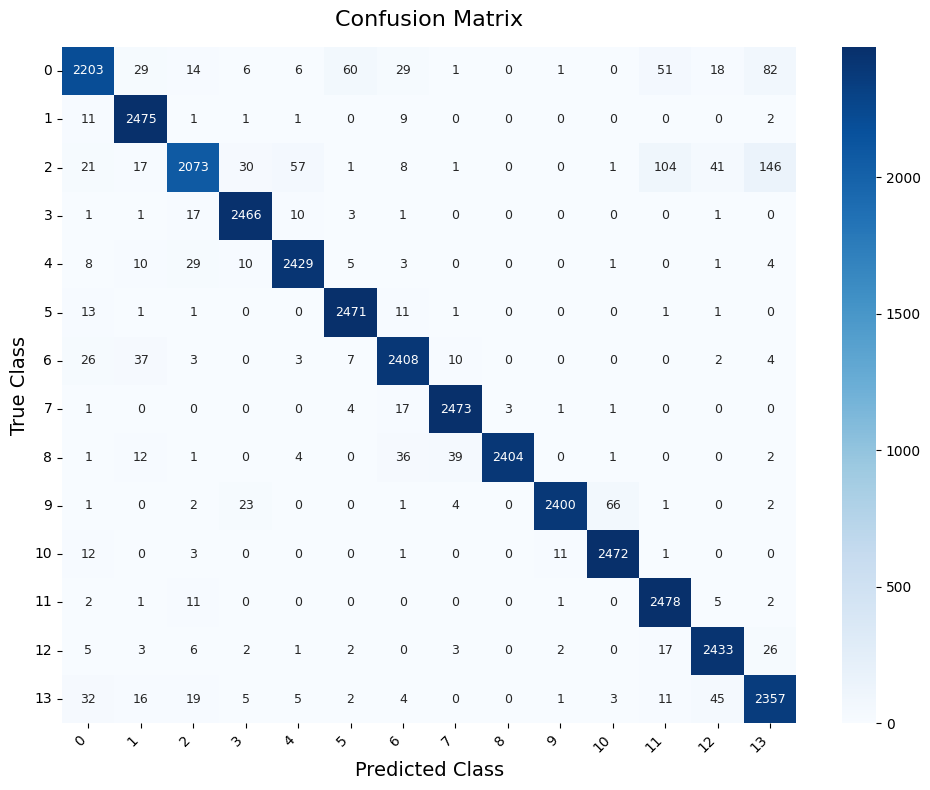

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(df, true_col="label", pred_col="Predicted"):
    # Compute confusion matrix
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(df[true_col].unique())

    # Create a bigger, clearer plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True,          # display numbers
        fmt='d',             # integer format
        cmap='Blues',        # color map
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True,
        annot_kws={"size": 9}  # adjust font size for annotations
    )

    plt.title("Confusion Matrix", fontsize=16, pad=15)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(data_test, true_col="label", pred_col="Predicted")

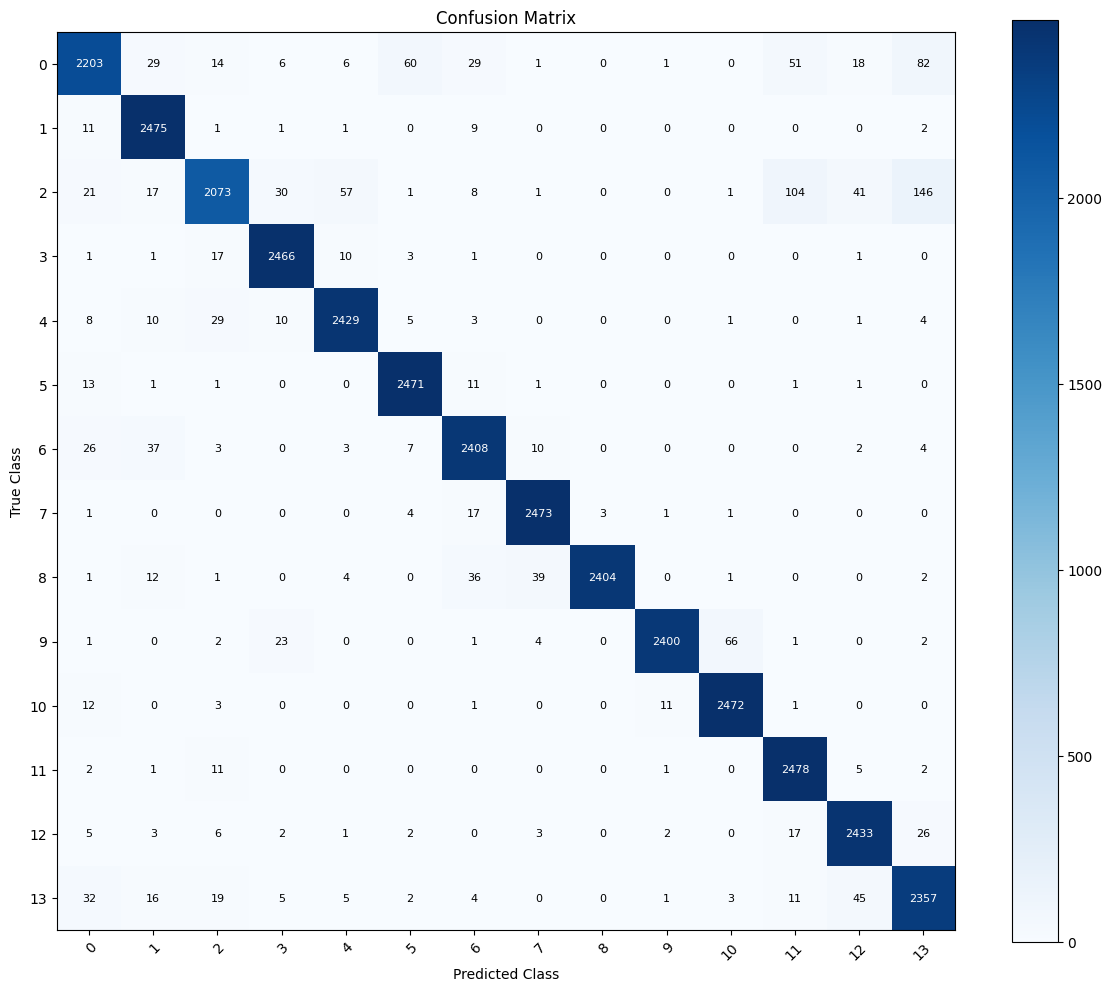

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(df, true_col="label", pred_col="Predicted"):
    # Compute confusion matrix
    cm = confusion_matrix(df[true_col], df[pred_col])
    labels = sorted(df[true_col].unique())
    n_classes = len(labels)

    fig, ax = plt.subplots(figsize=(12, 10))  # Bigger figure for clarity
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # Titles and labels
    ax.set(
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels,
        title="Confusion Matrix",
        xlabel="Predicted Class",
        ylabel="True Class"
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Display counts in each cell
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    fontsize=8 if n_classes > 10 else 10,
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()
plot_confusion_matrix(data_test, true_col="label", pred_col="Predicted")


Using Trigram 

In [ ]:

class NaiveBayesMultifeatureTrigram:
    def __init__(self):
        self.prob_classes = {}
        self.word_probs = {}
        self.vocab = {}
        self.smoothening = None
        self.classes = None
        self.feature_types = ['content', 'title']
        pass

    def make_bigrams(self,tokens):
        trigrams = []
        trigrams.extend(tokens)
        for i in range(len(tokens)-2):
            trigrams.append(tokens[i] + " " + tokens[i+1] + " " + tokens[i+2])
        return trigrams

    def preprocess_text(self,df, text_col="content"):
        """
        Apply stemming + stopword removal to tokenized text in the DataFrame.
        Args:
            df (pd.DataFrame): DataFrame with tokenized text column
            text_col (str): Column containing list of tokens
        Returns:
            pd.DataFrame with updated text_col
        """
        stemmer = SnowballStemmer("english")
        stop_words = set(stopwords.words("english"))
        
        df[text_col] = df[text_col].apply(
            lambda tokens: [
                stemmer.stem(w) 
                for w in tokens 
                if w.lower() not in stop_words and w.isalpha()  # keep only non-stopwords + alphabetic
            ]
        )
        return df

        
    def fit(self, df, smoothening,class_col = "label"):
        """Learn the parameters of the model from the training data.
        Classes are 1-indexed

        Args:
            df (pd.DataFrame): The training data containing columns class_col and text_col.
                each entry of text_col is a list of tokens.
            smoothening (float): The Laplace smoothening parameter.
        """
        for feature_type in self.feature_types:
            df = self.preprocess_text(df, feature_type)

        
        self.smoothening = smoothening
        self.classes = sorted(df[class_col].unique())
        

        for cls in self.classes:
            class_cnt = len(df[df[class_col] == cls])
            self.prob_classes[cls] = class_cnt / len(df)
        
      

        for feature_type in self.feature_types:
            self.vocab[feature_type] = set()
            self.word_probs[feature_type] = {} 

            all_words = []
            for tokens in df[feature_type]:
                features = self.make_bigrams(tokens)
                all_words.extend(features)
                self.vocab[feature_type].update(features)

            self.vocab[feature_type].add("<UNK>")



        token_count = {feature_type : { c : defaultdict(int) for c in self.classes} for feature_type in self.feature_types}
        total_token_per_class = {feature_type : { c : 0 for c in self.classes} for feature_type in self.feature_types}



        for feature_type in self.feature_types:
            for _,row in df.iterrows():
                cls = row[class_col]
                tokens = row[feature_type]
                features = self.make_bigrams(tokens)

                for feature in features :

                    token_count[feature_type][cls][feature] += 1
                    total_token_per_class[feature_type][cls] += 1

        for feature_type in self.feature_types:
            vocab_size = len(self.vocab[feature_type]) 

            for cls in self.classes:
                self.word_probs[feature_type][cls] = {}

                denom = total_token_per_class[feature_type][cls] + smoothening * vocab_size

                for word in self.vocab[feature_type]:
                    if word == "<UNK>":
                        cnt = 0
                    else:
                        cnt = token_count[feature_type][cls].get(word, 0)
                    cnt += smoothening
                    self.word_probs[feature_type][cls][word] = cnt / denom        



        pass
    
    def predict(self, df, predicted_col = "Predicted"):
        """
        Predict the class of the input data by filling up column predicted_col in the input dataframe.

        Args:
            df (pd.DataFrame): The testing data containing column text_col.
                each entry of text_col is a list of tokens.

                
        """
        for feature_type in self.feature_types:
            df = self.preprocess_text(df, feature_type)


        predictions = []
        unknown_word_count = 0
        total_word_count = 0


        for _ , row in df.iterrows():
            log_probs = {}

            for c in self.classes:
                log_probs[c] = math.log(self.prob_classes[c])

                for feature_type in self.feature_types:
                    tokens = row[feature_type]

                    features = self.make_bigrams(tokens)

                    for feature in features:
                        if feature not in self.word_probs[feature_type][c]:
                            feature = "<UNK>"
                            unknown_word_count += 1
                        log_probs[c] += math.log(self.word_probs[feature_type][c][feature])
                        total_word_count += 1
            best_class = max(log_probs, key=log_probs.get)
            predictions.append(best_class)

        df[predicted_col] = predictions

          
        
        print(self.accuracy(df, class_col = "label", predicted_col = predicted_col))
        print(f"unknown_word_count: {unknown_word_count}, total_word_count: {total_word_count}")
        pass

    def accuracy(self, df, class_col = "label", predicted_col = "Predicted"):
        """
        Compute the accuracy of the model on the given data.

        Args:
            df (pd.DataFrame): The data containing columns class_col and predicted_col.
        Returns:
            float: The accuracy of the model on the given data.
        """
        correct = (df[class_col] == df[predicted_col]).sum()
        total = len(df)
        return correct / total
    
    def plot_wordcloud(self, class_label, max_words=100):
        """
        Generate and display a word cloud for the given class.
        Args:
            class_label: the class to visualize
            max_words: max number of words in the word cloud
        """
        if class_label not in self.word_probs:
            raise ValueError(f"Class {class_label} not found. Available: {list(self.word_probs.keys())}")
        
        word_freqs = self.word_probs[class_label]

        wc = WordCloud(width=800, height=400, 
                       background_color='white', 
                       max_words=max_words).generate_from_frequencies(word_freqs)

        plt.figure(figsize=(10, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for class {class_label}", fontsize=16)
        plt.show()

In [ ]:
data = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")
data['content'] = data['content'].str.split()
data['title'] = data['title'].str.split()
data_test['title'] = data_test['title'].str.split()
data_test['content'] = data_test['content'].str.split()

In [ ]:
NB_Multi = NaiveBayesMultifeatureTrigram()
NB_Multi.fit(data, smoothening = 1.0, class_col = "label")
NB_Multi.predict(data_test, predicted_col = "Predicted")
NB_Multi.predict(data, predicted_col = "Predicted")
print(f"accuracy on test data: {accuracy(data_test, class_col = 'label', predicted_col = 'Predicted')}")
for i in range(14):
    print(f"precison and recall for class {i}: {precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i)}")
    print(f"f1 score for class {i}: {f1_score(*precision_recall(data_test, class_col = 'label', predicted_col = 'Predicted', positive_class=i))}") 

0.9526571428571429
unknown_word_count: 8974028, total_word_count: 22584366
0.9950928571428571
unknown_word_count: 75502, total_word_count: 89889716
accuracy on test data: 0.9526571428571429
precison and recall for class 0: (0.9259415996614473, 0.8752)
f1 score for class 0: 0.8998560559325519
precison and recall for class 1: (0.9521586931155193, 0.9792)
f1 score for class 1: 0.9654900414119503
precison and recall for class 2: (0.9330905780609923, 0.82)
f1 score for class 2: 0.8728975942090696
precison and recall for class 3: (0.9687252573238322, 0.9788)
f1 score for class 3: 0.9737365698368484
precison and recall for class 4: (0.9596199524940617, 0.9696)
f1 score for class 4: 0.9645841623557502
precison and recall for class 5: (0.9607003891050584, 0.9876)
f1 score for class 5: 0.9739644970414201
precison and recall for class 6: (0.9423076923076923, 0.9604)
f1 score for class 6: 0.9512678288431061
precison and recall for class 7: (0.9773988897700238, 0.986)
f1 score for class 7: 0.981680

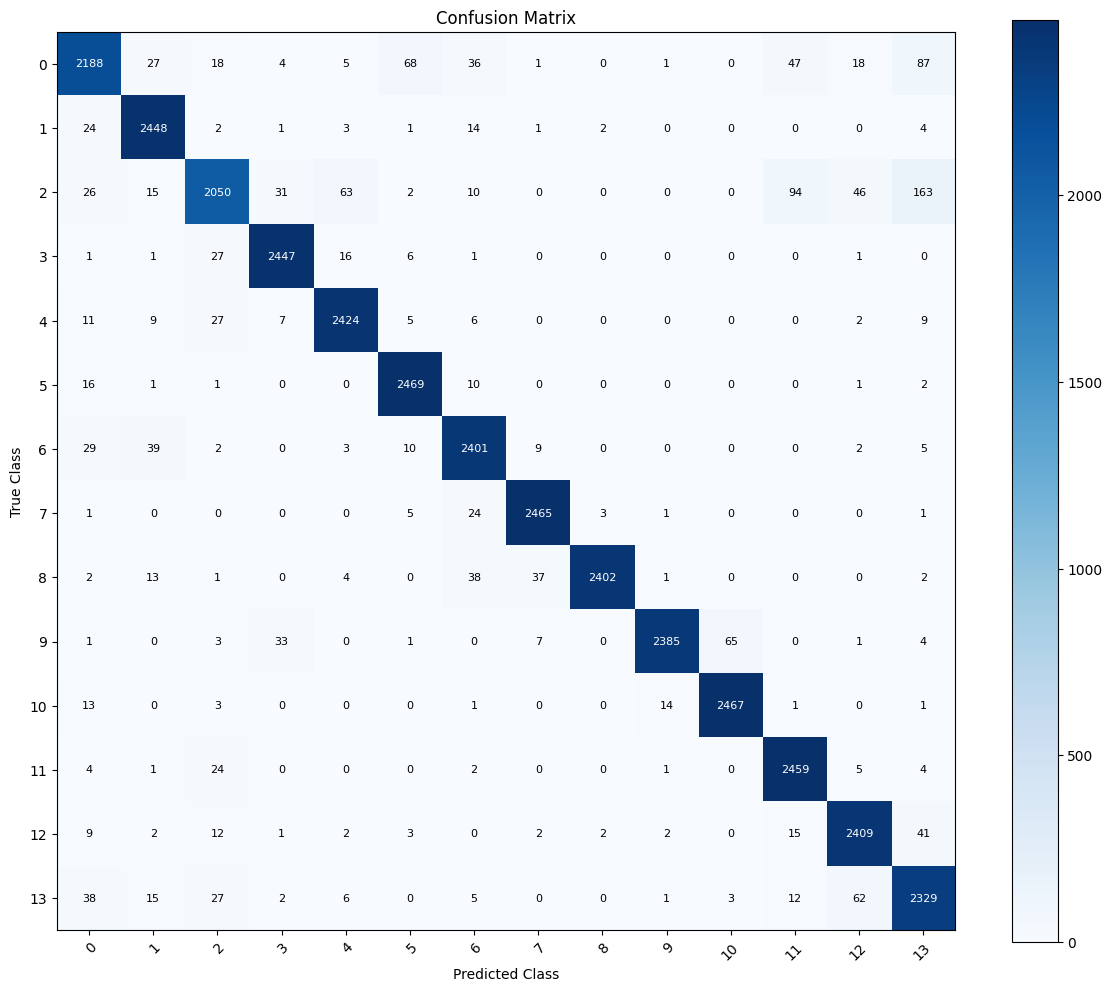

In [ ]:
plot_confusion_matrix(data_test, true_col="label", pred_col="Predicted")